# Tutorial 7: Batch avatarization

In this tutorial, we will perform the avatarization on data batches. This can be useful if you have a dataset too large to be avatarized in one shot.


This is the general workflow of the anonymization using batch.


 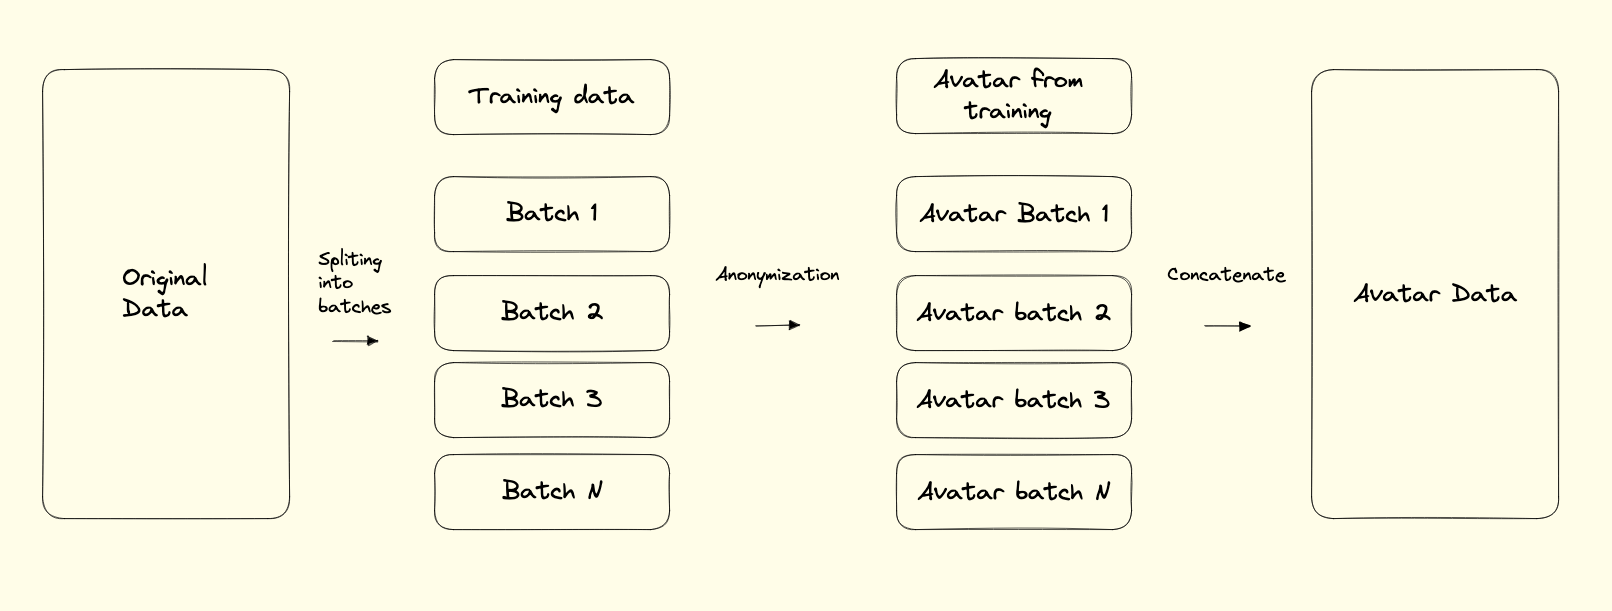
 

## Connection

In [ ]:
import os

url = os.environ.get("AVATAR_BASE_URL")
username = os.environ.get("AVATAR_USERNAME")
password = os.environ.get("AVATAR_PASSWORD")

In [ ]:
from avatars.api import (
    download_sensitive_unshuffled_avatar_dataframe_from_batch,
    upload_batch_and_get_order,
    download_avatar_dataframe_from_batch,
)

from avatars.lib.split import get_split_for_batch

from avatars.client import ApiClient

from avatars.models import (
    AvatarizationBatchParameters,
    AvatarizationBatchJobCreate,
    CommonPrivacyMetricsParameters,
    PrivacyMetricsBatchJobCreate,
    PrivacyMetricsBatchParameters,
    CommonSignalMetricsParameters,
    SignalMetricsBatchJobCreate,
    SignalMetricsBatchParameters,
    ImputationParameters,
    ImputeMethod,
)


import pandas as pd

In [ ]:
# Change this to your actual server endpoint, e.g. base_url="https://avatar.company.com"
client = ApiClient(base_url=url)
client.authenticate(username=username, password=password)

# Verify that we can connect to the API server
client.health.get_health()

## Load the data
We will use a subset of the dataset `adult_with_missing`.

In [ ]:
df = pd.read_csv("../fixtures/adult_with_missing.csv").head(1000)

In [ ]:
# create some batches from the df

row_limit = 200

training, splits = get_split_for_batch(
    df,
    row_limit=row_limit,
)

## Launch batch avatarization


In [ ]:
dataset_training_id, dataset_split_ids, order = upload_batch_and_get_order(
    client=client, training=training, splits=splits, timeout=100
)


batch_job = client.jobs.create_avatarization_batch_job(
    AvatarizationBatchJobCreate(
        parameters=AvatarizationBatchParameters(
            training_dataset_id=dataset_training_id,
            dataset_ids=dataset_split_ids,
            k=20,
            imputation=ImputationParameters(method=ImputeMethod.mean),
        ),
        timeout=100,
    )
)
batch_job = client.jobs.get_avatarization_batch_job(batch_job.id, timeout=100)
batch_job

## Launch privacy metrics per batch

In [ ]:
privacy_job_ref = client.jobs.create_privacy_metrics_batch_job(
    PrivacyMetricsBatchJobCreate(
        parameters=PrivacyMetricsBatchParameters(
            avatarization_batch_job_id=batch_job.id,
            common_parameters=CommonPrivacyMetricsParameters(
                imputation=ImputationParameters(method=ImputeMethod.mean)
            ),
        ),
    ),
    timeout=100,
)
privacy_job = client.jobs.get_privacy_metrics_batch_job(privacy_job_ref.id, timeout=100)
# you can access batch-averaged metrics
print("Mean metrics")
print(privacy_job.result.mean_metrics)

# you can access the worst metrics over all batches
print("Worst metrics")
print(privacy_job.result.worst_metrics)

## Launch signal metrics per batch 


In [ ]:
signal_job_training = client.jobs.create_signal_metrics_batch_job(
    SignalMetricsBatchJobCreate(
        parameters=SignalMetricsBatchParameters(
            avatarization_batch_job_id=batch_job.id,
            common_parameters=CommonSignalMetricsParameters(),
        ),
    ),
    timeout=100,
)
signal_job = client.jobs.get_signal_metrics_batch_job(
    signal_job_training.id, timeout=100
)

print("Mean metrics")
print(signal_job.result.mean_metrics)

## Build the anonymized dataset



### Get the shuffled avatar dataframe

In [ ]:
avatars = download_avatar_dataframe_from_batch(
    client=client, avatarization_batch_result=batch_job.result, timeout=100
)
avatars.head()

###  Get the sensitive unshuffled avatar dataframe

In [ ]:
sensitive_avatars = download_sensitive_unshuffled_avatar_dataframe_from_batch(
    client=client,
    avatarization_batch_result=batch_job.result,
    order=order,
    timeout=100,
)
sensitive_avatars.head()